In [1]:
## %matplotlib notebook
%matplotlib inline
import numpy as np

import datetime
import matplotlib.pyplot as plt
import matplotlib
from cycler import cycler
_colc = matplotlib.rcParams['axes.prop_cycle'].concat(cycler(color=['blue', 'black']))
import pickle
import chempl as chemplay
cs = chemplay.Consts()
from sci2tex import sci2tex

In [2]:
matplotlib.rcParams['font.size'] = 12

In [4]:
# define utility functions

def preps(c_):
    c_.assort_reactions()
    c_.assignElementsToSpecies()
    c_.calculateSpeciesMasses()
    c_.calculateSpeciesVibFreqs()
    c_.calculateSpeciesDiffBarriers()
    c_.calculateSpeciesQuantumMobilities()
    c_.calculateReactionHeat()
    c_.classifySpeciesByPhase()
    c_.assignReactionHandlers()
    
def run_many_models(models, t_ratio=1.08, dt0=1e-1, interruptMode=True,
                    t_max_s=1e7*cs.phy_SecondsPerYear, nmax=2000,
                    do_something=None, **kargs):
    t_start = datetime.datetime.now()
    store = [{'ts': [], 'ys': [], 'finished': False,
              'y': [_ for _ in m.abundances], 't': 0.0, 'dt': dt0}
             for m in models]
    for i,m in enumerate(models):
        m.set_solver(solver_id=i)
    all_finished = False
    for i in range(nmax):
        for s, m in zip(store,models):
            if s['finished']:
                continue
            s['t'], s['y'] = m.update(s['y'], t=s['t'], dt=s['dt'], interruptMode=interruptMode)
            s['ts'].append(s['t'])
            s['ys'].append(s['y'])
            s['dt'] *= t_ratio
            if s['t']+s['dt'] > t_max_s:
                s['dt'] = t_max_s - s['t']
            if s['t'] >= t_max_s:
                s['finished'] = True
        all_finished = all([s['finished'] for s in store])
        if do_something and (i%10==1 or all_finished):
            do_something(store, **kargs)
        if all_finished:
            break
    print((datetime.datetime.now() - t_start).total_seconds(), 'seconds elapsed')
    return store

def update_curves(store, **kargs):
    for s, Lines, indices in zip(store, kargs['lines'], kargs['indices']):
        for L,idx in zip(Lines, indices):
            if idx is None:
                continue
            L.set_data(np.array(s['ts'])/cs.phy_SecondsPerYear,
                       [_[idx] for _ in s['ys']])
    kargs['fig'].canvas.draw()
    return

def get_production_reactions(s, c_):
    return sorted([r for r in c_.reactions if s in r['products']], key=lambda x: -x['rate'])

phy_params_default = {
    b'Av': 20.0,
    b'G0_UV': 1.0,
    b'Ncol_H2': 4e22,
    b'T_dust': 15.0,
    b'T_gas': 15.0,
    b'chemdesorption_factor': 0.05,
    b'chi_Xray': 0.0,
    b'chi_cosmicray': 1.0,
    b'dust2gas_mass': 1e-2,
    b'dust_albedo': 0.6,
    b'dust_material_density': 2.0,
    b'dust_radius': 0.1e-4,
    b'dust_site_density': 1e15,
    b'dv_km_s': 1.0,
    b'mean_mol_weight': 1.4,
    b'n_gas': 5e4,
    b't_max_year': 1e7}

def draw_ratios(models, stores, ratio_pairs, ratioratio=False, t_range=None,
                timeslice=None, colors=[_['color'] for _ in _colc],
                xscale='log', yscale='log',
                xlabel='', ylabel='', lgd_str='', param_str=b'',
                xlim=(1e5, 1e6), ylim=(1e-6,1e-4)):
    fig = plt.figure(figsize=(7,4))
    ax = fig.add_axes([0.13,0.13,0.82,0.83])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid(axis='both', which='both')
    def at_(y, i):
        if i is None:
            return 1.0
        return y[i]
    i_start = 0
    for im,(m,s) in enumerate(zip(models, stores)):
        ts = np.array(s['ts'])/cs.phy_SecondsPerYear
        tslice_idx = []
        if timeslice is not None:
            for t_ in timeslice:
                tslice_idx.append(np.argmin(np.abs(ts-t_)))
        if t_range is None:
            t_range = (ts[0], ts[-1])
        tidx = np.logical_and(ts >= t_range[0], ts <= t_range[1])
        if ratioratio:
            r1,r2 = ratio_pairs[0]
            i1 = m.name2idx.get(r1)
            i2 = m.name2idx.get(r2)
            xvals = np.array([at_(y,i1)/at_(y,i2) for y in s['ys']])
            i_start = 1
        else:
            xvals = ts
        for ic, (r1,r2) in enumerate(ratio_pairs[i_start:]):
            i1 = m.name2idx.get(r1)
            i2 = m.name2idx.get(r2)
            ratios = np.array([at_(y,i1)/at_(y,i2) for y in s['ys']])
            ax.plot(xvals[tidx], ratios[tidx], color=colors[im],
                    label=lgd_str.format(m.get_phy_param(param_str)))
            if tslice_idx:
                x_, y_ = zip(*[(xvals[i_], ratios[i_]) for i_ in tslice_idx])
                ax.plot(x_, y_, marker='s', markersize=7,
                        ls='none', color='white', zorder=100)
                ax.plot(x_, y_, marker='s', markersize=5, color=colors[im],
                        ls='none', zorder=100)
    ax.legend()
    return


def draw_time_slice(models, stores,
                timeslice=None, colors=[_['color'] for _ in _colc],
                xscale='log', yscale='log',
                xlabel='', ylabel='', lgd_str='', param_str=b'',
                xlim=(1e5, 1e6), ylim=(1e-6,1e-4)):
    fig = plt.figure(figsize=(7,4))
    ax = fig.add_axes([0.13,0.13,0.85,0.86])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid(axis='both', which='both')
    def at_(y, i):
        if i is None:
            return 1.0
        return y[i]
    i_start = 0
    for im,(m,s) in enumerate(zip(models, stores)):
        ts = np.array(s['ts'])/cs.phy_SecondsPerYear
        tslice_idx = []
        if timeslice is not None:
            for t_ in timeslice:
                tslice_idx.append(np.argmin(np.abs(ts-t_)))
        if t_range is None:
            t_range = (ts[0], ts[-1])
        tidx = np.logical_and(ts >= t_range[0], ts <= t_range[1])
        if ratioratio:
            r1,r2 = ratio_pairs[0]
            i1 = m.name2idx.get(r1)
            i2 = m.name2idx.get(r2)
            xvals = np.array([at_(y,i1)/at_(y,i2) for y in s['ys']])
            i_start = 1
        else:
            xvals = ts
        for ic, (r1,r2) in enumerate(ratio_pairs[i_start:]):
            i1 = m.name2idx.get(r1)
            i2 = m.name2idx.get(r2)
            ratios = np.array([at_(y,i1)/at_(y,i2) for y in s['ys']])
            ax.plot(xvals[tidx], ratios[tidx], color=colors[im],
                    label=lgd_str.format(m.get_phy_param(param_str)))
            if tslice_idx:
                x_, y_ = zip(*[(xvals[i_], ratios[i_]) for i_ in tslice_idx])
                ax.plot(x_, y_, marker='s', markersize=7,
                        ls='none', color='white', zorder=100)
                ax.plot(x_, y_, marker='s', markersize=5, color=colors[im],
                        ls='none', zorder=100)
    ax.legend()
    return

def draw_slope(ax, slope=0, T0=14, T1=20, v0=-7, v1=None,
               lw=5, color=(0.3,0.3,0.3,0.4), zorder=-100):
    if v1 is not None:
        slope = (v1-v0)/(T1-T0)
    v1 = v0 + slope * (T1-T0)
    ax.plot([T0,T1], 10**np.array([v0,v1]), lw=lw,
            color=color, zorder=zorder)

In [4]:
# for p in dir(cdata_s[0]):
#     try:
#         with open('/Users/fjdu/tmp/pick/' + p + '.pickle', 'wb') as f:
#             pickle.dump(cdata_s[0].__getattribute__(p), f)
#     except:
#         print('Cannot pickle', p)

# 同时改变温度和密度，使用较低的氘丰度和较高的碳氧丰度

**Ref**: Figure 1 of http://articles.adsabs.harvard.edu/pdf/2010IAUS..268..179L

$$\frac{n}{10^4} + T = 23$$

In [5]:
n = 6
cdata_s = [chemplay.ChemModel() for i in range(n)]

for i,c_ in enumerate(cdata_s):
    c_.clear_reactions()
    c_.load_reactions(b'rate12_only_gas_phase_isotopized_driven.dat')
    c_.loadSpeciesEnthalpies(b'Species_enthalpy.dat')
    c_.loadInitialAbundances(b'initial_abundances.dat')
    c_.setAbundanceByName(b'HD', 3e-6)
    c_.setAbundanceByName(b'O', 5e-4)
    c_.setAbundanceByName(b'C', 2e-4)
    c_.set_phy_params_by_dict(phy_params_default)
    c_.set_phy_params_by_dict({b'T_gas':12.0+i*2, b'T_dust':12.0+i*2,
                               b'n_gas':1e4*(11-i*2),
                               b'chemdesorption_factor':0.1,
                               b'chi_cosmicray': 1e0})
    preps(c_)

In [6]:
8e4*10**-0.6, 3.2e-4/10**-0.2, 5e-4*1.4/3.2

(20095.091452076642, 0.0005071658215875564, 0.00021874999999999998)

In [7]:
cdata_s[5].get_all_phy_params()
print(cdata_s[5].get_all_phy_params())

{b'Av': 20.0, b'G0_UV': 1.0, b'Ncol_CO': 0.0, b'Ncol_H': 0.0, b'Ncol_H2': 4e+22, b'T_dust': 22.0, b'T_gas': 22.0, b'chemdesorption_factor': 0.1, b'chi_Xray': 0.0, b'chi_cosmicray': 1.0, b'dust2gas_mass': 0.01, b'dust2gas_num': 2.7951629199813483e-12, b'dust_albedo': 0.6, b'dust_crosssec': 3.141592653589794e-10, b'dust_material_density': 2.0, b'dust_radius': 1e-05, b'dust_site_density': 1000000000000000.0, b'dv_km_s': 1.0, b'mean_mol_weight': 1.4, b'n_gas': 10000.0, b't_max_year': 10000000.0, b'v_km_s': 0.0}


In [8]:
c_ = cdata_s[0]
for k in c_.name2idx:
    if c_.abundances[c_.name2idx[k]] > 1e-20:
        print(k, c_.abundances[c_.name2idx[k]])

b'C' 0.0002
b'Cl' 4e-09
b'F' 2e-08
b'Fe' 3e-09
b'H2' 0.5
b'HD' 3e-06
b'He' 0.09
b'Mg' 7e-09
b'N' 7.5e-05
b'Na' 2e-08
b'O' 0.0005
b'P' 3e-09
b'S' 8e-08
b'Si' 8e-09


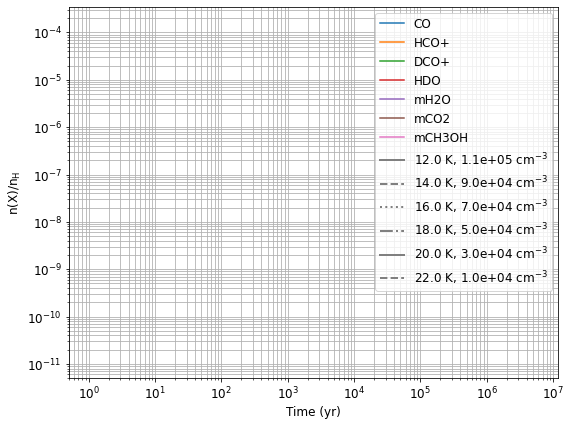

In [10]:
species_draw = [b'CO', b'HCO+', b'DCO+', b'HDO', b'mH2O', b'mCO2', b'mCH3OH']
ls_s = ['-', '--', ':', '-.', '-', '--']
plab_s = ['{:} K, {:.1e} cm$^{{-3}}$'.format(c_.get_phy_param(b'T_gas'), c_.get_phy_param(b'n_gas'))
          for c_ in cdata_s]

fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0.13,0.13,0.85,0.86])
ax.set_xlabel('Time (yr)')
ax.set_ylabel('n(X)/n$_{\\rm H}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((5e-1, 1.2e7))
ax.set_ylim((5e-12, 3.5e-4))
ax.grid(axis='both', which='both')

Ls = []
for i in range(n):
    ax.set_prop_cycle(_colc)
    Ls.append([ax.plot([], [], ls=ls_s[i], label=s.decode())[0]
               for s in species_draw])
    
    if i == 0:
        for _,_l in zip(ls_s,plab_s):
            ax.plot([],[], ls=_, label=_l, color='gray',lw=2)
        ax.legend(fontsize=12)

In [11]:
store = run_many_models(cdata_s, do_something=update_curves,
                lines=Ls,
                indices=[[m.name2idx.get(s) for s in species_draw]
                         for m in cdata_s],
                fig=fig)

Making sparse...
NNZ = 55065 (0.0395468)
RWORK size = 354010
IWORK size = 56276
Making sparse...
NNZ = 55065 (0.0395468)
RWORK size = 354010
IWORK size = 56276
Making sparse...
NNZ = 55065 (0.0395468)
RWORK size = 354010
IWORK size = 56276
Making sparse...
NNZ = 55065 (0.0395468)
RWORK size = 354010
IWORK size = 56276
Making sparse...
NNZ = 55065 (0.0395468)
RWORK size = 354010
IWORK size = 56276
Making sparse...
NNZ = 55065 (0.0395468)
RWORK size = 354010
IWORK size = 56276
0         -> 0.1       ISTATE=2 #f=29 #jac=2 LRW=250446 LIW=56276 NNZ=55068 SID=0
0         -> 0.1       ISTATE=2 #f=31 #jac=2 LRW=250446 LIW=56276 NNZ=55068 SID=1
0         -> 0.1       ISTATE=2 #f=38 #jac=2 LRW=250446 LIW=56276 NNZ=55068 SID=2
0         -> 0.1       ISTATE=2 #f=55 #jac=2 LRW=250446 LIW=56276 NNZ=55068 SID=3
0         -> 0.1       ISTATE=2 #f=89 #jac=2 LRW=250446 LIW=56276 NNZ=55068 SID=4
0         -> 0.1       ISTATE=2 #f=102 #jac=2 LRW=250446 LIW=56276 NNZ=55068 SID=5
0.1       -> 0.208     ISTA

In [12]:
with open('2020-03-30-CO-depletion-and-deuteration-SYFeng.pickle', 'wb') as f:
    pickle.dump(store, f)

In [13]:
import os
with open(os.path.join(os.path.expanduser('./'),
             '2020-03-30-CO-depletion-and-deuteration-SYFeng.pickle'), 'rb') as f:
    store = pickle.load(f)

In [14]:
from scipy.stats import gaussian_kde

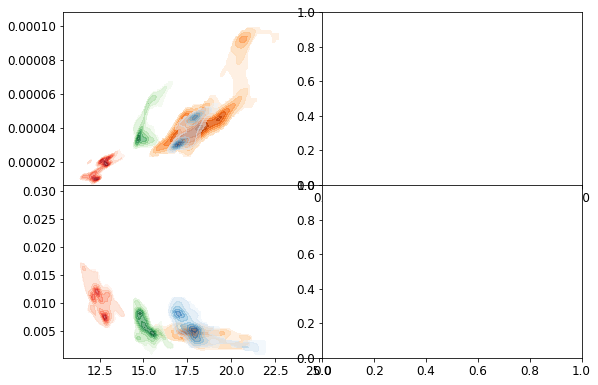

In [15]:
fig = plt.figure(figsize=(9,6))
ax_s = [fig.add_axes([0.15,0.55,0.4,0.4]),
        fig.add_axes([0.15,0.15,0.4,0.4]),
        fig.add_axes([0.55,0.55,0.4,0.4]),
        fig.add_axes([0.55,0.15,0.4,0.4])]

dat_dir = './txtfile/'
import os

cms = [matplotlib.cm.Reds, matplotlib.cm.Oranges, matplotlib.cm.Blues, matplotlib.cm.Greens]
alphas = [0.6, 0.8, 0.5, 0.6]
i = 0

for fCO, fDXHCOp in [
    ('G11_3811-Tdust-XCO-point-all.txt', 'G11_3811-Tdust-DXHCOp-point-all.txt'),
    ('G14_4876-Tdust-XCO-point-all.txt', 'G14_4876-Tdust-DXHCOp-point-all.txt'),
    ('G15_2169-Tdust-XCO-point-all.txt', 'G15_2169-Tdust-DXHCOp-point-all.txt'),
    ('G34_7391-Tdust-XCO-point-all.txt', 'G34_7391-Tdust-DXHCOp-point-all.txt'),
    ]:
    d_CO = np.loadtxt(os.path.join(dat_dir, fCO), skiprows=2)
    d_DCO = np.loadtxt(os.path.join(dat_dir, fDXHCOp), skiprows=2)
    iax = 0
    for _d in [d_CO, d_DCO]:
        #counts,xbins,ybins,image = plt.hist2d(_d[:,0], 10**_d[:,1], bins=50, density=True, cmin=1e1, cmap=cm)
        #counts[np.logical_not(np.isnan(counts))] = 1
        #counts[np.isnan(counts)] = 0
        y = 10**_d[:,1]
        kde = gaussian_kde(np.vstack([_d[:,0], y]))
        
        minx, maxx = _d[:,0].min()/1.1, _d[:,0].max()*1.1
        miny, maxy = y.min()/1.1, y.max()*1.1
        xx, yy = np.meshgrid(np.linspace(minx, maxx, num=100), np.linspace(miny, maxy, num=50))
        zz = np.reshape(kde(np.vstack([xx.ravel(), yy.ravel()])).T, xx.shape)
        zmin, zmax = zz.min(), zz.max()
        zz[zz < zmax*0.07] = np.nan
        C = ax_s[iax].contourf(xx, yy, zz, cmap=cms[i], alpha=alphas[i])
        
        iax += 1
    
    i += 1

# for ax in ax_s[0:2]:
#     ax.set_xscale('linear')
#     ax.set_yscale('log')
#     ax.set_xlim((11,23))
#     ax.grid(axis='both', which='both', color=(0.8,0.8,0.8), alpha=0.2)
# ax_s[0].set_ylim((6e-7, 2e-4))
# ax_s[1].set_ylim((1e-3, 2e-1))

# plt.savefig('x.pdf')

In [91]:
#fig = plt.figure(figsize=(7,4))
#ax = fig.add_axes([0.15,0.15,0.82,0.83])

tpoints = [4e4, 8e4, 1.2e5, 1.6e5]
Trange = (11,23)
nRange = (0.8e4,1.2e5)
COrange = (5e-6, 1.6e-4)
DCOprange = (0.9e-3, 9e-2)

ax = ax_s[0]
ax.set_xlabel('$T$ (K)')
ax.set_ylabel(r'n(CO)/n$_{\rm H}$')
ax.set_xscale('linear')
ax.set_yscale('log')
ax.set_xlim(Trange)
ax.set_ylim(COrange)
ax.grid(axis='both', which='both', color=(0.8,0.8,0.8), alpha=0.2)
ax.set_prop_cycle(_colc)
colors = [_['color'] for _ in _colc]

for itp,tp in enumerate(tpoints):
    Ts = []
    vals = []
    for i,(d,m) in enumerate(zip(cdata_s, store)):
        ix = d.name2idx[b'CO']
        ts = np.array(m['ts']) / cs.phy_SecondsPerYear
        y = np.array([_[ix] for _ in m['ys']])
        ix_t = np.argmin(np.abs(ts - tp))
        Ts.append(d.get_phy_param(b'T_gas'))
        vals.append(y[ix_t])
    ax.plot(Ts, vals, ls='-', color='white', lw=4,
            marker='o', markersize=5)
    ax.plot(Ts, vals, ls='-', color=colors[itp], lw=2,
            marker='o', markersize=4, label='t=$'+sci2tex('{:.0e}'.format(tp))+'$yr')
#ax.legend(loc='upper right')
ax.text(0.06, 0.91, '(a)', horizontalalignment='center', transform=ax.transAxes)
#draw_slope(ax, T0=13, v0=-4.7, T1=21, v1=-4.3, lw=10)
#plt.savefig('T_vs_CO.pdf', bbox_inches='tight')

#fig = plt.figure(figsize=(7,4))
ax = ax_s[1]
ax.set_xlabel('$T$ (K)')
ax.set_ylabel('$n({\\rm DCO}^+)/n({\\rm HCO}^+)$')
ax.set_xscale('linear')
ax.set_yscale('log')
ax.set_xlim(Trange)
ax.set_ylim(DCOprange)
ax.grid(axis='both', which='both', color=(0.8,0.8,0.8), alpha=0.2)
ax.set_prop_cycle(_colc)
colors = [_['color'] for _ in _colc]

for itp,tp in enumerate(tpoints):
    Ts = []
    vals = []
    for i,(d,m) in enumerate(zip(cdata_s, store)):
        ix1,ix2 = d.name2idx[b'DCO+'], d.name2idx[b'HCO+']
        ts = np.array(m['ts']) / cs.phy_SecondsPerYear
        y = np.array([_[ix1]/(_[ix2]+1e-30) for _ in m['ys']])
        ix_t = np.argmin(np.abs(ts - tp))
        Ts.append(d.get_phy_param(b'T_gas'))
        vals.append(y[ix_t])
    ax.plot(Ts, vals, ls='-', color='white', lw=4,
            marker='o', markersize=5)
    ax.plot(Ts, vals, ls='-', color=colors[itp], lw=2,
            marker='o', markersize=4, label='t=$'+sci2tex('{:.0e}'.format(tp))+'$yr')
ax.text(0.06, 0.91, '(b)', horizontalalignment='center', transform=ax.transAxes)

ax = ax_s[2]
#ax.set_xlabel('$n_{{\\rm H}}$ (cm$^{-3}$)')
#ax.set_ylabel(r'n(CO)/n$_{\rm H}$')
ax.set_xscale('linear')
ax.set_yscale('log')
ax.set_xlim(nRange)
ax.set_ylim(COrange)
ax.grid(axis='both', which='both', color=(0.8,0.8,0.8), alpha=0.2)
ax.set_prop_cycle(_colc)
colors = [_['color'] for _ in _colc]

for itp,tp in enumerate(tpoints):
    Ts = []
    vals = []
    for i,(d,m) in enumerate(zip(cdata_s, store)):
        ix = d.name2idx[b'CO']
        ts = np.array(m['ts']) / cs.phy_SecondsPerYear
        y = np.array([_[ix] for _ in m['ys']])
        ix_t = np.argmin(np.abs(ts - tp))
        Ts.append(d.get_phy_param(b'n_gas'))
        vals.append(y[ix_t])
    ax.plot(Ts, vals, ls='-', color='white', lw=4,
            marker='o', markersize=5)
    ax.plot(Ts, vals, ls='-', color=colors[itp], lw=2,
            marker='o', markersize=4, label='$t='+sci2tex('{:.1e}'.format(tp))+'$yr')
    ax.text(Ts[2]*1.05, vals[2]*1.1, '$t='+sci2tex('{:.1e}'.format(tp))+'$yr',
            horizontalalignment='center', verticalalignment='bottom', weight='normal', color='k')
ax.text(0.06, 0.91, '(c)', horizontalalignment='center', transform=ax.transAxes)
xticks = [_ for _ in filter(lambda x: x<=9e4 and x>=1e4, ax.get_xticks())]
ax.set_xticks(xticks)
_ = ax.set_xticklabels(['$'+sci2tex('{:.2e}'.format(_))+'$' for _ in xticks])

ax = ax_s[3]
ax.set_xlabel('$n_{{\\rm H}}$ (cm$^{-3}$)')
#ax.set_ylabel(r'DCO$^+$/HCO$^+$')
ax.set_xscale('linear')
ax.set_yscale('log')
ax.set_xlim(nRange)
ax.set_ylim(DCOprange)
ax.grid(axis='both', which='both', color=(0.8,0.8,0.8), alpha=0.2)
ax.set_prop_cycle(_colc)
colors = [_['color'] for _ in _colc]

for itp,tp in enumerate(tpoints):
    Ts = []
    vals = []
    for i,(d,m) in enumerate(zip(cdata_s, store)):
        ix1,ix2 = d.name2idx[b'DCO+'], d.name2idx[b'HCO+']
        ts = np.array(m['ts']) / cs.phy_SecondsPerYear
        y = np.array([_[ix1]/(_[ix2]+1e-30) for _ in m['ys']])
        ix_t = np.argmin(np.abs(ts - tp))
        Ts.append(d.get_phy_param(b'n_gas'))
        vals.append(y[ix_t])
    ax.plot(Ts, vals, ls='-', color='white', lw=4,
            marker='o', markersize=5)
    ax.plot(Ts, vals, ls='-', color=colors[itp], lw=2,
            marker='o', markersize=4, label='t=$'+sci2tex('{:.0e}'.format(tp))+'$yr')
ax.text(0.06, 0.91, '(d)', horizontalalignment='center', transform=ax.transAxes)
xticks = [_ for _ in filter(lambda x: x<=1.1e5 and x>=1e4, ax.get_xticks())]
ax.set_xticks(xticks)
_ = ax.set_xticklabels(['$'+sci2tex('{:.2e}'.format(_))+'$' for _ in xticks])

In [94]:
ax_s[0].set_xticklabels([])
ax_s[2].set_yticklabels([])
ax_s[2].set_xticklabels([])
ax_s[3].set_yticklabels([])
for ax in ax_s:
    ax.tick_params(which='both', direction='in', length=3, width=1, grid_alpha=0.2)

In [95]:
plt.savefig('n_T_vs_CO_DCO+_HCO+_CRs.pdf', bbox_inches='tight')

# 同上，但使用不同的宇宙线电离率

In [59]:
n = 6
cdata_s = [chemplay.ChemModel() for i in range(n)]

for i,c_ in enumerate(cdata_s):
    c_.clear_reactions()
    c_.load_reactions(b'rate12_only_gas_phase_isotopized_driven.dat')
    c_.loadSpeciesEnthalpies(b'Species_enthalpy.dat')
    c_.loadInitialAbundances(b'initial_abundances.dat')
    c_.setAbundanceByName(b'HD', 3e-6)
    c_.setAbundanceByName(b'O', 5e-4)
    c_.setAbundanceByName(b'C', 2e-4)
    c_.set_phy_params_by_dict(phy_params_default)
    c_.set_phy_params_by_dict({b'T_gas':12.0+i*2, b'T_dust':12.0+i*2,
                               b'n_gas':1e4*(11-i*2),
                               b'chemdesorption_factor':0.1,
                               b'chi_cosmicray': 1e1})
    preps(c_)

In [60]:
store_CR10 = run_many_models(cdata_s)

430.857358 seconds elapsed


In [92]:
ax = ax_s[0]
# ax.set_xscale('linear')
# ax.set_yscale('log')
# ax.set_xlim((13,21))
# ax.set_ylim((8e-7, 2e-4))

for itp,tp in enumerate(tpoints):
    Ts = []
    vals = []
    for i,(d,m) in enumerate(zip(cdata_s, store_CR10)):
        ix = d.name2idx[b'CO']
        ts = np.array(m['ts']) / cs.phy_SecondsPerYear
        y = np.array([_[ix] for _ in m['ys']])
        ix_t = np.argmin(np.abs(ts - tp))
        Ts.append(d.get_phy_param(b'T_gas'))
        vals.append(y[ix_t])
    ax.plot(Ts, vals, ls='--', color=colors[itp], lw=1.5)
    
ax = ax_s[1]
# ax.set_xscale('linear')
# ax.set_yscale('log')
# ax.set_xlim((13,21))
# ax.set_ylim((1e-3, 2e-1))

for itp,tp in enumerate(tpoints):
    Ts = []
    vals = []
    for i,(d,m) in enumerate(zip(cdata_s, store_CR10)):
        ix1,ix2 = d.name2idx[b'DCO+'], d.name2idx[b'HCO+']
        ts = np.array(m['ts']) / cs.phy_SecondsPerYear
        y = np.array([_[ix1]/_[ix2] for _ in m['ys']])
        ix_t = np.argmin(np.abs(ts - tp))
        Ts.append(d.get_phy_param(b'T_gas'))
        vals.append(y[ix_t])
    ax.plot(Ts, vals, ls='--', color=colors[itp], lw=1.5)

In [61]:
n = 6
cdata_s = [chemplay.ChemModel() for i in range(n)]

for i,c_ in enumerate(cdata_s):
    c_.clear_reactions()
    c_.load_reactions(b'rate12_only_gas_phase_isotopized_driven.dat')
    c_.loadSpeciesEnthalpies(b'Species_enthalpy.dat')
    c_.loadInitialAbundances(b'initial_abundances.dat')
    c_.setAbundanceByName(b'HD', 3e-6)
    c_.setAbundanceByName(b'O', 5e-4)
    c_.setAbundanceByName(b'C', 2e-4)
    c_.set_phy_params_by_dict(phy_params_default)
    c_.set_phy_params_by_dict({b'T_gas':12.0+i*2, b'T_dust':12.0+i*2,
                               b'n_gas':1e4*(11-i*2),
                               b'chemdesorption_factor':0.1,
                               b'chi_cosmicray': 1e-1})
    preps(c_)

In [62]:
store_CR01 = run_many_models(cdata_s)

1276.372821 seconds elapsed


In [93]:
ax = ax_s[0]
# ax.set_xscale('linear')
# ax.set_yscale('log')
# ax.set_xlim((13,21))
# ax.set_ylim((8e-7, 2e-4))

for itp,tp in enumerate(tpoints):
    Ts = []
    vals = []
    for i,(d,m) in enumerate(zip(cdata_s, store_CR01)):
        ix = d.name2idx[b'CO']
        ts = np.array(m['ts']) / cs.phy_SecondsPerYear
        y = np.array([_[ix] for _ in m['ys']])
        ix_t = np.argmin(np.abs(ts - tp))
        Ts.append(d.get_phy_param(b'T_gas'))
        vals.append(y[ix_t])
    ax.plot(Ts, vals, ls=':', color=colors[itp], lw=1.5)
    
ax = ax_s[1]
# ax.set_xscale('linear')
# ax.set_yscale('log')
# ax.set_xlim((13,21))
# ax.set_ylim((1e-3, 2e-1))

for itp,tp in enumerate(tpoints):
    Ts = []
    vals = []
    for i,(d,m) in enumerate(zip(cdata_s, store_CR01)):
        ix1,ix2 = d.name2idx[b'DCO+'], d.name2idx[b'HCO+']
        ts = np.array(m['ts']) / cs.phy_SecondsPerYear
        y = np.array([_[ix1]/_[ix2] for _ in m['ys']])
        ix_t = np.argmin(np.abs(ts - tp))
        Ts.append(d.get_phy_param(b'T_gas'))
        vals.append(y[ix_t])
    ax.plot(Ts, vals, ls=':', color=colors[itp], lw=1.5)

<IPython.core.display.Javascript object>


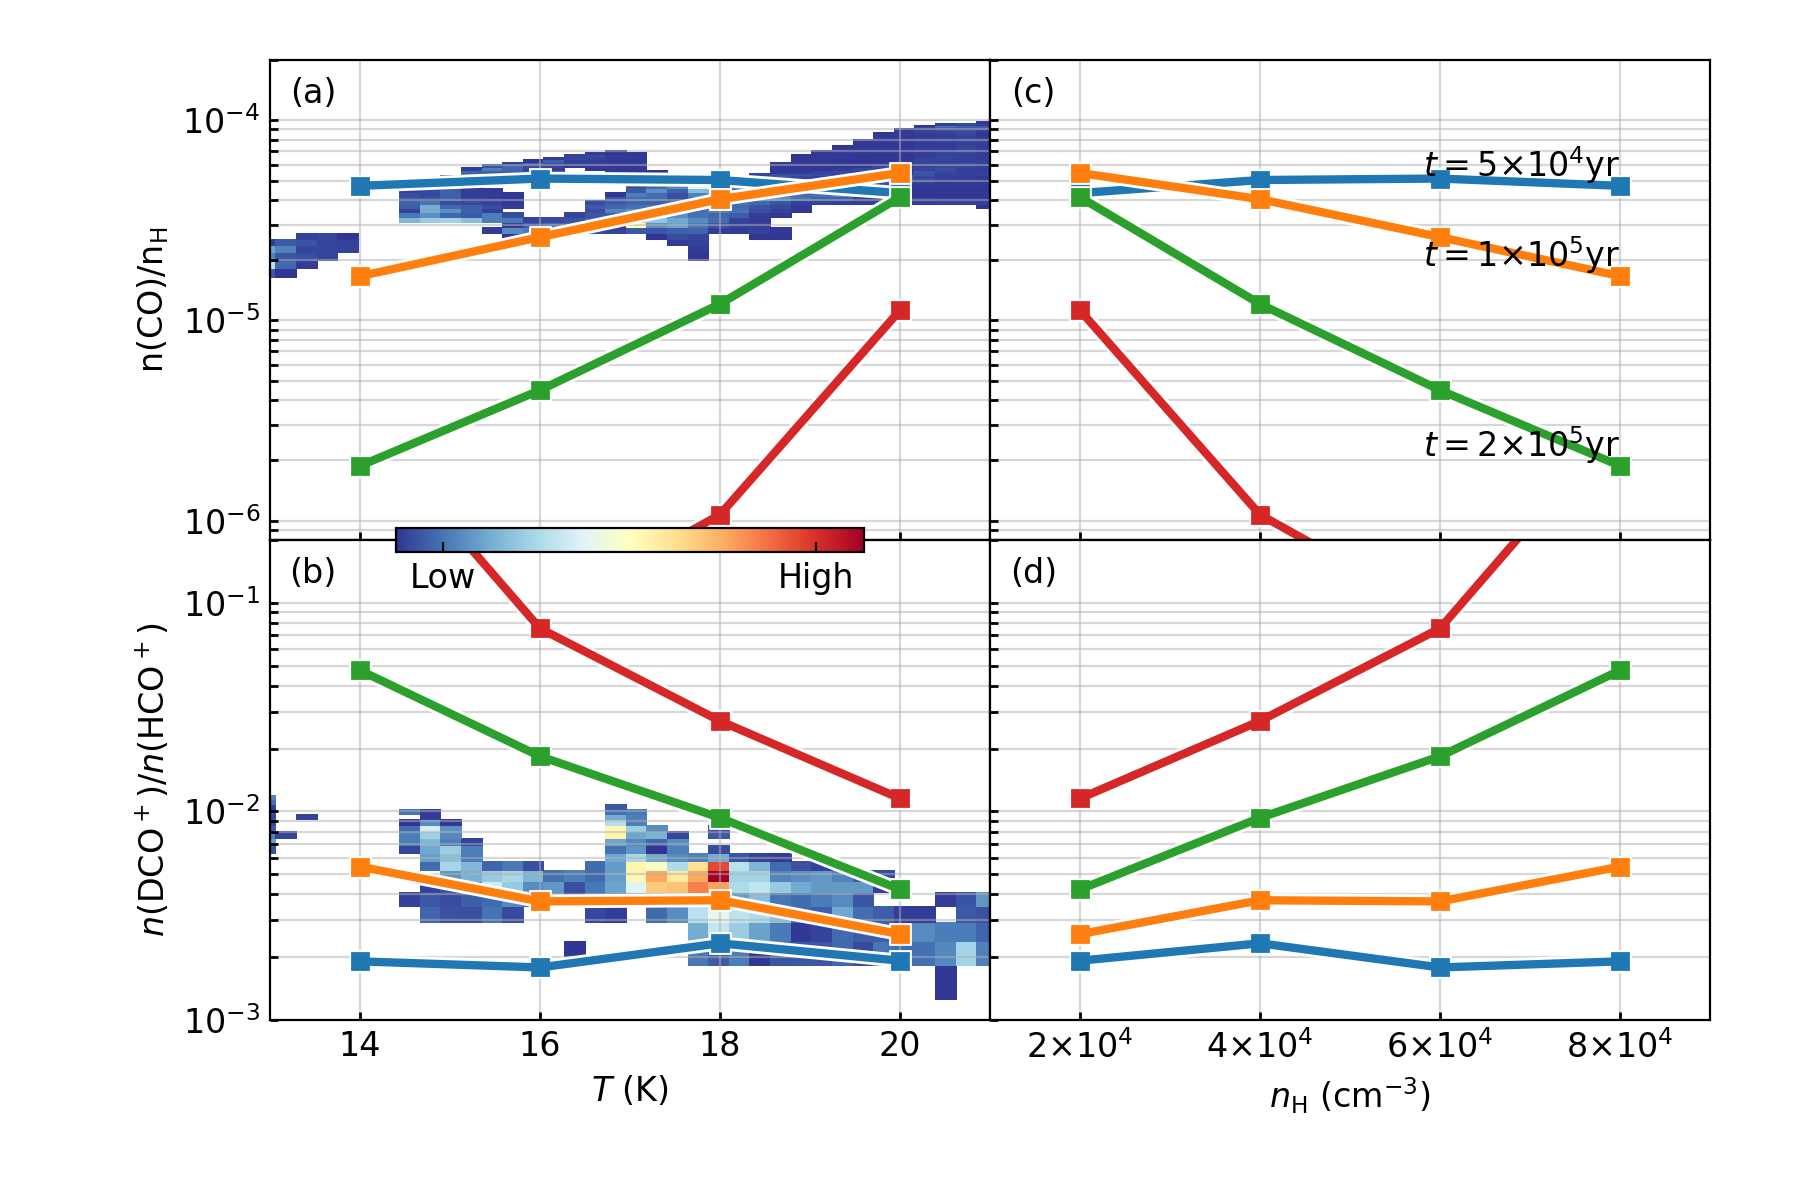

In [56]:
fig = plt.figure(figsize=(9,6))
ax_s = [fig.add_axes([0.15,0.55,0.4,0.4]),
        fig.add_axes([0.15,0.15,0.4,0.4]),
        fig.add_axes([0.55,0.55,0.4,0.4]),
        fig.add_axes([0.55,0.15,0.4,0.4])]

# 固定温度，改变密度

In [59]:
n = 4
cdata_s = [chemplay.pyUserData() for i in range(n)]

for i,c_ in enumerate(cdata_s):
    c_.clear_reactions()
    c_.load_reactions(b'rate12_only_gas_phase_isotopized_driven.dat')
    c_.loadSpeciesEnthalpies(b'Species_enthalpy.dat')
    c_.loadInitialAbundances(b'initial_abundances.dat')
    c_.set_phy_params_by_dict(phy_params_default)
    c_.set_phy_params_by_dict({b'n_gas': 2e4*(1+i)})
    preps(c_)

<IPython.core.display.Javascript object>


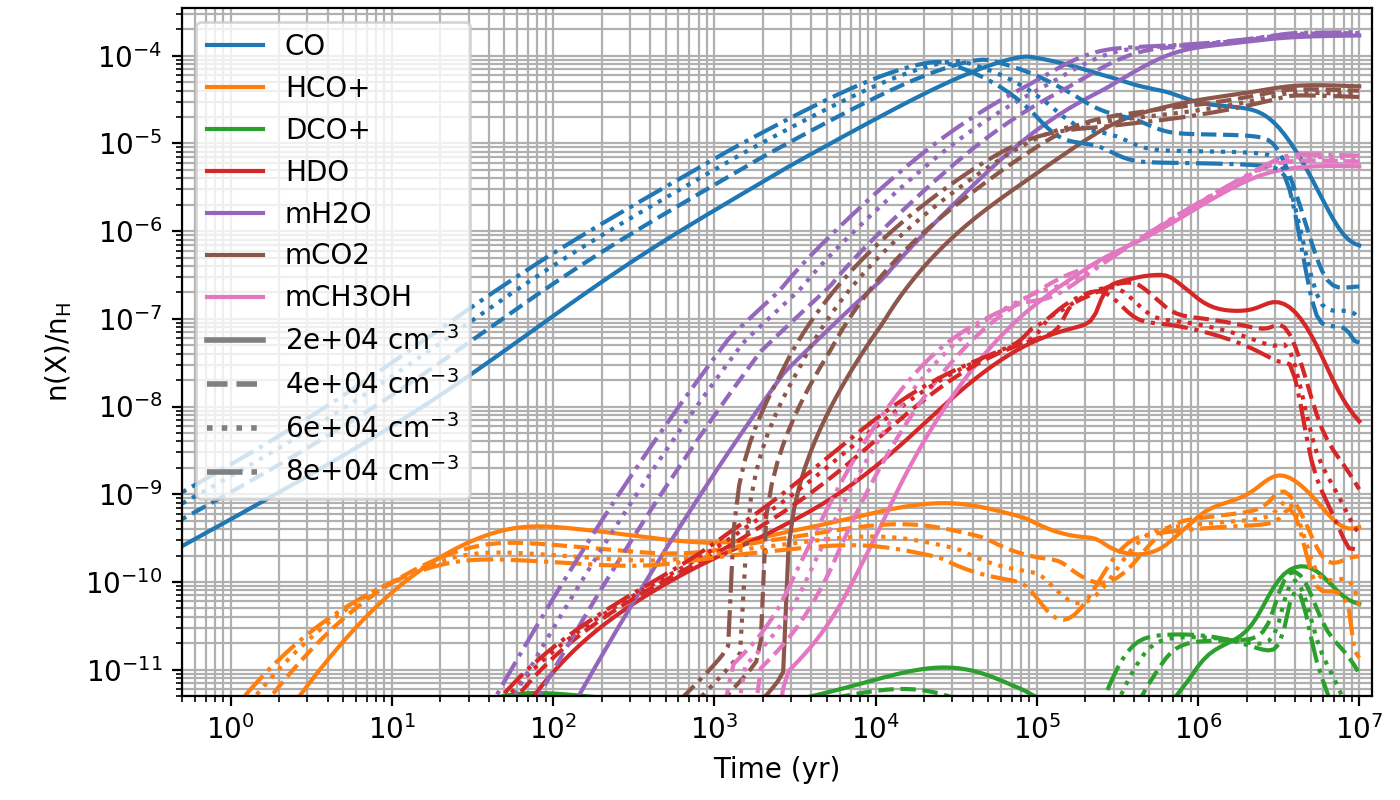

In [60]:
species_draw = [b'CO', b'HCO+', b'DCO+', b'HDO', b'mH2O', b'mCO2', b'mCH3OH']
ls_s = ['-', '--', ':', '-.']
plab_s = ['{:.1g} cm$^{{-3}}$'.format(c_.get_phy_param(b'n_gas')) for c_ in cdata_s]

fig = plt.figure(figsize=(7,4))
ax = fig.add_axes([0.13,0.13,0.85,0.86])
ax.set_xlabel('Time (yr)')
ax.set_ylabel('n(X)/n$_{\\rm H}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim((5e-1, 1.2e7))
ax.set_ylim((5e-12, 3.5e-4))
ax.grid(axis='both', which='both')

Ls = []
for i in range(n):
    ax.set_prop_cycle(_colc)
    Ls.append([ax.plot([], [], ls=ls_s[i], label=s.decode())[0]
               for s in species_draw])
    
    if i == 0:
        for _,_l in zip(ls_s,plab_s):
            ax.plot([],[], ls=_, label=_l, color='gray',lw=2)
        ax.legend()

In [61]:
store = run_many_models(cdata_s, do_something=update_curves,
                lines=Ls,
                indices=[[m.name2idx.get(s) for s in species_draw]
                         for m in cdata_s],
                fig=fig)

517.689737 seconds elapsed


<IPython.core.display.Javascript object>


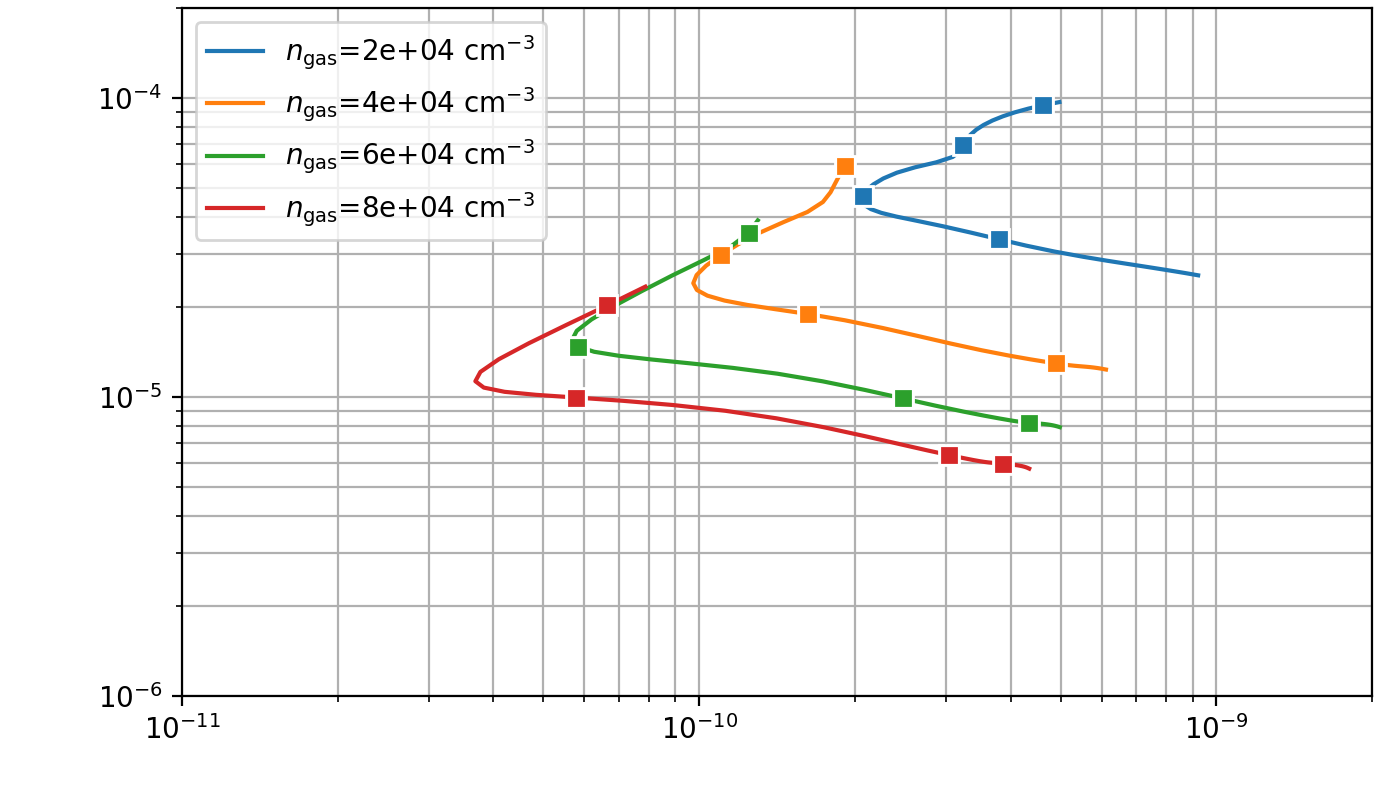

In [76]:
draw_ratios(cdata_s, store, [(b'HCO+', b''), (b'CO', b'')], ratioratio=True,
            xlim=(1e-11, 2e-9), ylim=(1e-6, 2e-4),
            lgd_str='$n_{{\\rm gas}}$={:.1g} cm$^{{-3}}$', param_str=b'n_gas',
            t_range=(0.9e5,2e6), timeslice=[1e5, 2e5, 4e5, 8e5])

<IPython.core.display.Javascript object>


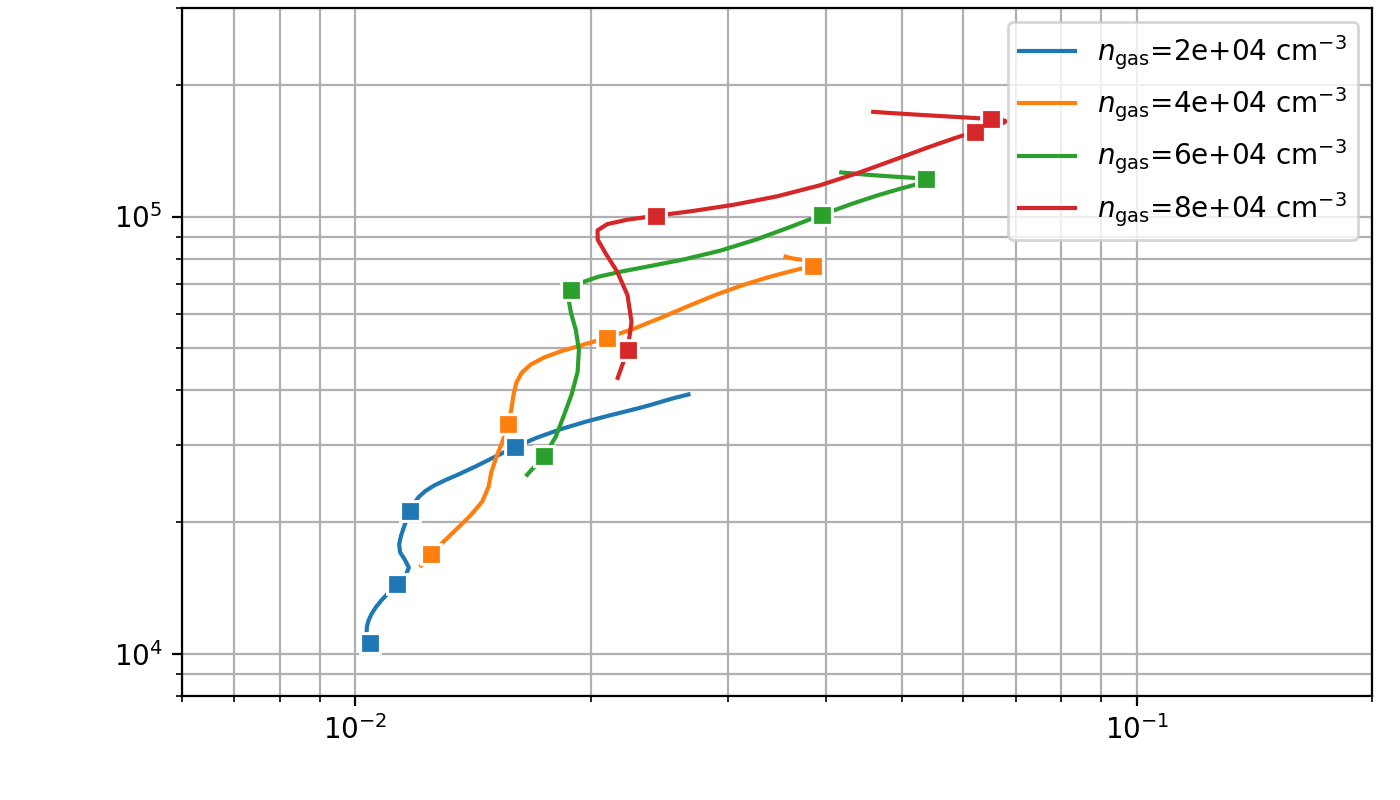

In [81]:
draw_ratios(cdata_s, store, [(b'DCO+', b'HCO+'), (b'', b'CO')], ratioratio=True,
            xlim=(6e-3, 2e-1), ylim=(8e3, 3e5),
            lgd_str='$n_{{\\rm gas}}$={:.1g} cm$^{{-3}}$', param_str=b'n_gas',
            t_range=(0.9e5,2e6), timeslice=[1e5, 2e5, 4e5, 8e5])

In [42]:
# lg = ax.get_legend()
# lg.get_texts()[-4].set_text('$n_{{\\rm gas}}=2{{\\times}}10^4\;{{\\rm cm}}^{-3}$')
# lg.get_texts()[-3].set_text('$n_{{\\rm gas}}=4{{\\times}}10^4\;{{\\rm cm}}^{-3}$')
# lg.get_texts()[-2].set_text('$n_{{\\rm gas}}=6{{\\times}}10^4\;{{\\rm cm}}^{-3}$')
# lg.get_texts()[-1].set_text('$n_{{\\rm gas}}=8{{\\times}}10^4\;{{\\rm cm}}^{-3}$')

In [15]:
# for r in cdata_s[0].reactions:
#     if r['heat'] > 0.0 and r['rate'] > 1e-60:
#         print(r)